In [ ]:
import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output
import tensorflow as tf

In [ ]:
import tensorflow_datasets as tfds


In [ ]:
!apt remove git -y -9

E: Command line option '9' [from -9] is not understood in combination with the other options.


In [ ]:
!apt-get update && apt-get install git -y && git clone https://github.com/tensorflow/examples.git

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Get:8 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [9,087 kB]
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:10 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:12 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy/main amd64 Packages [32.9 kB]
Get:13 http://security.ubuntu.com/ubuntu jammy-security

In [ ]:
tf.random.set_seed(789)

loading the dataset

In [ ]:
dataset, metadata =tfds.load('cycle_gan/apple2orange',with_info=True, as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/4 [00:00<?, ? splits/s]

Generating trainA examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/cycle_gan/apple2orange/incomplete.MWXDL2_3.0.0/cycle_gan-trainA.tfrecord*.…

Generating trainB examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/cycle_gan/apple2orange/incomplete.MWXDL2_3.0.0/cycle_gan-trainB.tfrecord*.…

Generating testA examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/cycle_gan/apple2orange/incomplete.MWXDL2_3.0.0/cycle_gan-testA.tfrecord*..…

Generating testB examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/cycle_gan/apple2orange/incomplete.MWXDL2_3.0.0/cycle_gan-testB.tfrecord*..…

Dataset cycle_gan downloaded and prepared to /root/tensorflow_datasets/cycle_gan/apple2orange/3.0.0. Subsequent calls will reuse this data.


In [ ]:
training_A,training_B=dataset['trainA'],dataset['trainB']
testing_A,testing_B=dataset['testA'],dataset['testB']

In [ ]:
quantity_training=len(training_A)
quantity_training

995

In [ ]:
buffer_size=quantity_training
batch_size=1
img_width=256
img_height=256

functions of preprocessing


In [ ]:
def random_crop(img):
  img_crop=tf.image.random_crop(img,size=[img_width,img_height,3])
  return img_crop

In [ ]:
def normalize(img):
  img=tf.cast(img,tf.float32)
  img=(img/127.5)-1
  return img

In [ ]:

def random_jitter(img):
  img=tf.image.resize(img,[286,286],method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  img=random_crop(img)
  img=tf.image.random_flip_left_right(img)
  return img

In [ ]:
def process_training_img(img,label):
  img=random_jitter(img)
  img=normalize(img)
  return img

In [ ]:
def process_testing_img(img,label):
  img=normalize(img)
  return img

loading the dataset

In [ ]:
 training_A=training_A.cache().map(process_training_img,num_parallel_calls=tf.data.AUTOTUNE).shuffle(buffer_size).batch(batch_size)
 training_B=training_B.cache().map(process_training_img,num_parallel_calls=tf.data.AUTOTUNE).shuffle(buffer_size).batch(batch_size)
 testing_A=testing_A.cache().map(process_testing_img,num_parallel_calls=tf.data.AUTOTUNE).shuffle(buffer_size).batch(batch_size)
 testing_B=testing_B.cache().map(process_testing_img,num_parallel_calls=tf.data.AUTOTUNE).shuffle(buffer_size).batch(batch_size)

In [ ]:
type(training_A)

tensorflow.python.data.ops.batch_op._BatchDataset

In [ ]:
sample_A=next(iter(training_A))
sample_B=next(iter(training_B))

Apple


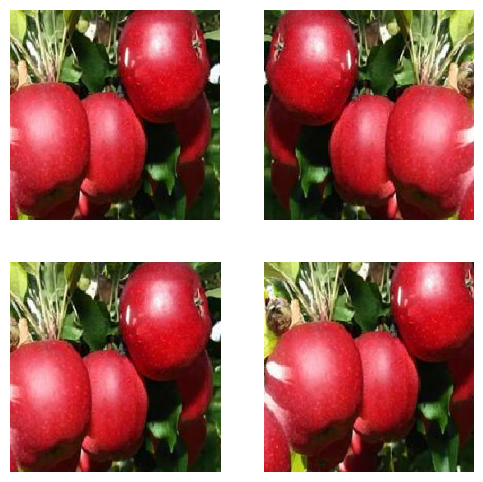

In [ ]:
print('Apple')
plt.figure(figsize=(6,6))
for i in range(4):
  A_jitter=random_jitter(sample_A[0])
  plt.subplot(2,2,i+1)
  plt.imshow( A_jitter*0.5+0.5)
  plt.axis('off')
plt.show()

Orange


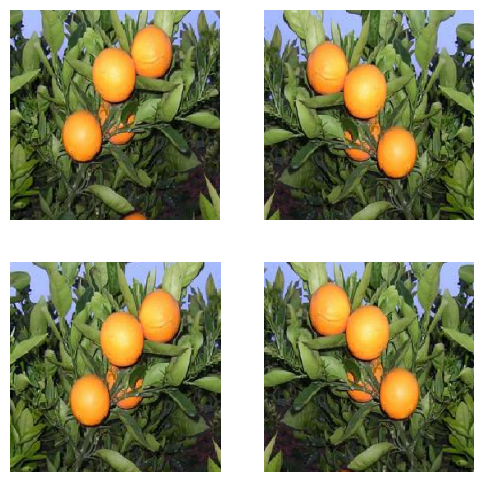

In [ ]:
print('Orange')
plt.figure(figsize=(6,6))
for i in range(4):
  A_jitter=random_jitter(sample_B[0])
  plt.subplot(2,2,i+1)
  #plt.imshow(sample_B[0]*0.5+0.5)
  plt.imshow( A_jitter*0.5+0.5)
  plt.axis('off')
plt.show()

generator and discriminator

In [ ]:
import sys
sys.path.append('examples/tensorflow_examples/models/pix2pix')
import pix2pix

In [ ]:
!ls -R examples/tensorflow_examples

examples/tensorflow_examples:
__init__.py  lite  models  profiling

examples/tensorflow_examples/lite:
__init__.py  model_maker

examples/tensorflow_examples/lite/model_maker:
cli   __init__.py  README.md		     requirements.txt
core  pip_package  RELEASE.md		     third_party
demo  public	   requirements_nightly.txt

examples/tensorflow_examples/lite/model_maker/cli:
cli.py	cli_test.py  __init__.py

examples/tensorflow_examples/lite/model_maker/core:
api	   data_util	     file_util.py  optimization  test_util.py
compat.py  export_format.py  __init__.py   task		 utils

examples/tensorflow_examples/lite/model_maker/core/api:
api_gen.py	 api_util_test.py   golden_api.json
api_gen_test.py  deprecated_api.py  include.py
api_util.py	 golden_api_doc.py  __init__.py

examples/tensorflow_examples/lite/model_maker/core/data_util:
audio_dataloader.py		    object_detector_dataloader_util.py
audio_dataloader_test.py	    object_detector_dataloader_util_test.py
dataloader.py			    recommendation_confi

In [ ]:
!ls -a examples/tensorflow_examples/models/pix2pix

.  ..  data_download.py  __init__.py  pix2pix.py  pix2pix_test.py  __pycache__


In [ ]:
output_channels=3
generator_g=pix2pix.unet_generator(output_channels,norm_type='instancenorm')
generator_f=pix2pix.unet_generator(output_channels,norm_type='instancenorm')
discriminator_x=pix2pix.discriminator(norm_type='instancenorm',target=False)
discriminator_y=pix2pix.discriminator(norm_type='instancenorm',target=False)


cyclegan algorithm

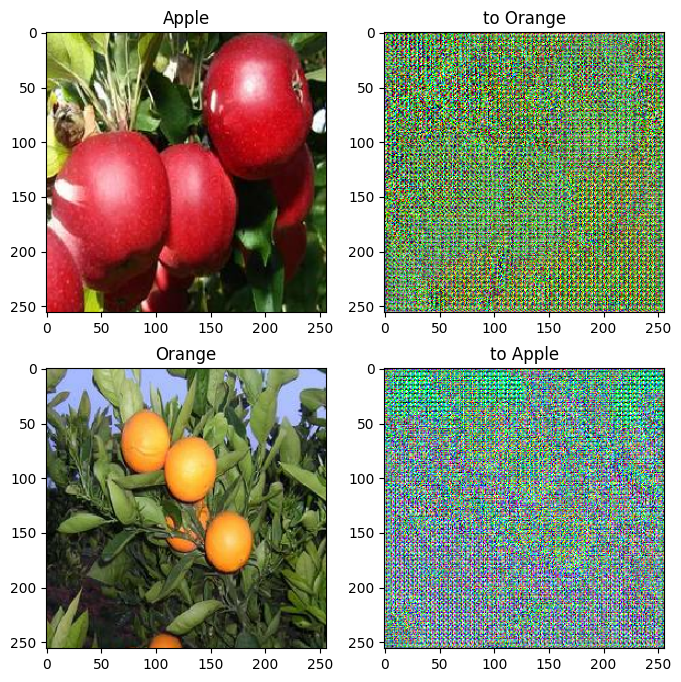

In [ ]:
B_generated=generator_g(sample_A)
A_generated=generator_f(sample_B)
plt.figure(figsize=(8,8))
imgs=[sample_A,B_generated,sample_B,A_generated]
title=['Apple','to Orange','Orange','to Apple']
for i in range(len(imgs)):
  plt.subplot(2,2,i+1)
  plt.title(title[i])
  if i%2==0:
    plt.imshow(imgs[i][0]*0.5+0.5)
  else:
    plt.imshow(imgs[i][0]*0.5*6+0.5)
plt.show()

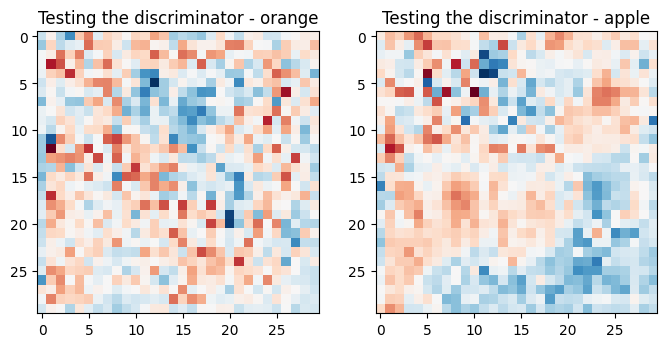

In [ ]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.title('Testing the discriminator - orange')
plt.imshow(discriminator_y(sample_B)[0, ..., -1],cmap='RdBu_r')

plt.subplot(1,2,2)
plt.title('Testing the discriminator - apple')
plt.imshow(discriminator_x(sample_A)[0, ..., -1],cmap='RdBu_r')

plt.show()

loss


In [ ]:
lamda_=10
loss=tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def discriminator_loss(real,generated):
  real_loss=loss(tf.ones_like(real),real)
  generated_loss=loss(tf.zeros_like(generated),generated)
  d_total_loss=real_loss+generated_loss
  return d_total_loss

In [ ]:
def generator_loss(generated):
  return loss(tf.ones_like(generated),generated)

cycle consistency loss

In [ ]:
def cycle_loss(real_img,cycled_img):
  loss1=tf.reduce_mean(tf.abs(real_img-cycled_img))
  return lamda_*loss1

In [ ]:
def identity_loss(real_img,equal_img):
  loss=tf.reduce_mean(tf.abs(real_img-equal_img))
  return lamda_*0.5*loss

optimizers

In [ ]:
lr=0.0002
beta1,beta2=0.5,0.999

In [ ]:
optimizer_generator_g=tf.keras.optimizers.Adam(lr,beta_1=beta1,beta_2=beta2)
optimizer_generator_f=tf.keras.optimizers.Adam(lr,beta_1=beta1,beta_2=beta2)
optimizer_discriminator_x=tf.keras.optimizers.Adam(lr,beta_1=beta1,beta_2=beta2)
optimizer_discriminator_y=tf.keras.optimizers.Adam(lr,beta_1=beta1,beta_2=beta2)

In [ ]:
checkpoint_dir="./checkpoints/train"
checkpoint=tf.train.Checkpoint(generator_g=generator_g,
                               generator_f=generator_f,
                               discriminator_x=discriminator_x,
                               discriminator_y=discriminator_y,
                               generator_g_optimizer=optimizer_generator_g,
                               generator_f_optimizer=optimizer_generator_f,
                               discriminator_x_optimizer=optimizer_discriminator_x,
                               discriminator_y_optimizer=optimizer_discriminator_y)
checkpoint_manager=tf.train.CheckpointManager(checkpoint,checkpoint_dir,max_to_keep=5)
if checkpoint_manager.latest_checkpoint:
  checkpoint.restore(checkpoint_manager.latest_checkpoint)
  print('latest checkpoint restored')

training process

In [ ]:
epochs=10
def generate_images(model,test_input):
  generated=model(test_input)
  plt.figure(figsize=(8,6))
  list_imgs=[test_input[0],generated[0]]
  title=['Original','Output (generated)']
  for i in range(2):
    plt.subplot(1,2,i+1)
    plt.title(title[i])
    plt.imshow(list_imgs[i]*0.5+0.5)
    plt.axis('off')
  plt.show()

In [ ]:
@tf.function
def training_step(real_x,real_y):
  with tf.GradientTape(persistent=True) as tape:
    fake_y=generator_g(real_x,training=True)
    cycled_x=generator_f(fake_y,training=True)
    fake_x=generator_f(real_y,training=True)
    cycled_y=generator_g(fake_x,training=True)
    equal_x=generator_f(real_x,training=True)
    equal_y=generator_g(real_y,training=True)

    discriminator_real_x=discriminator_x(real_x,training=True)
    discriminator_fake_x=discriminator_x(fake_x,training=True)
    discriminator_real_y=discriminator_y(real_y,training=True)
    discriminator_fake_y=discriminator_y(fake_y,training=True)

    generator_g_loss=generator_loss(discriminator_fake_y)
    generator_f_loss=generator_loss(discriminator_fake_x)
    cycle_loss_total=cycle_loss(real_x,cycled_x)+cycle_loss(real_y,cycled_y)
    total_generator_g_loss=generator_g_loss+cycle_loss_total+identity_loss(real_y,equal_y)
    total_generator_f_loss=generator_f_loss+cycle_loss_total+identity_loss(real_x,equal_x)
    discriminator_x_loss=discriminator_loss(discriminator_real_x,discriminator_fake_x)
    discriminator_y_loss=discriminator_loss(discriminator_real_y,discriminator_fake_y)

    generator_g_gradients=tape.gradient(total_generator_g_loss,generator_g.trainable_variables)
    generator_f_gradients=tape.gradient(total_generator_f_loss,generator_f.trainable_variables)
    discriminator_x_gradients=tape.gradient(discriminator_x_loss,discriminator_x.trainable_variables)
    discriminator_y_gradients=tape.gradient(discriminator_y_loss,discriminator_y.trainable_variables)


    optimizer_generator_g.apply_gradients(zip(generator_g_gradients,generator_g.trainable_variables))
    optimizer_generator_f.apply_gradients(zip(generator_f_gradients,generator_f.trainable_variables))
    optimizer_discriminator_x.apply_gradients(zip(discriminator_x_gradients,discriminator_x.trainable_variables))
    optimizer_discriminator_y.apply_gradients(zip(discriminator_y_gradients,discriminator_y.trainable_variables))

In [ ]:
def train(training_A,training_B,generator_g,steps):
  for epoch in range(epochs):
    start=time.time()

    n=0
    for img_x,img_y in tf.data.Dataset.zip((training_A,training_B)):
      training_step(img_x,img_y)
      if n%10==0:
        print('.',end='')
      n==1

      clear_output(wait=True)
      generate_images(generator_g,sample_A)
      print('Time taken to train epoch {}: {} seconds\n'.format(epoch+1,time.time()-start))

      if(epoch+1)%5==0:
        checkpoint_dir_saved=checkpoint_manager.save()
        print('Checkpoint saved')
      generator_g.save_weights('model_cyclegan.weights.h5')

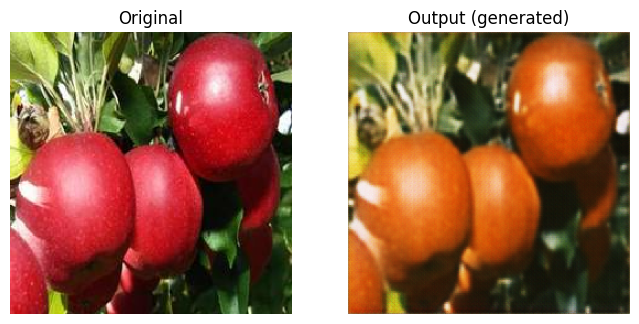

Time taken to train epoch 1: 1270.0890727043152 seconds



In [ ]:
train(training_A,training_B,generator_g,epochs)